In [18]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pydrake.geometry.optimization import HPolyhedron
from pydrake.trajectories import PiecewisePolynomial

from spp.bezier import BezierSPP
from spp.linear import LinearSPP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from scipy.spatial import ConvexHull

def plot_vpolytope(V, **kwargs):
    plt.fill(*V.T, **kwargs)
    
def make_hpolytope(V):
    ch = ConvexHull(V)
    return HPolyhedron(ch.equations[:, :-1], - ch.equations[:, -1])

In [20]:
from models.env_2d import obstacles, vertices

regions = [make_hpolytope(V) for V in vertices]

x_start = np.array([0, 0])
x_goal = np.array([4.8, 4.2])

<IPython.core.display.Javascript object>


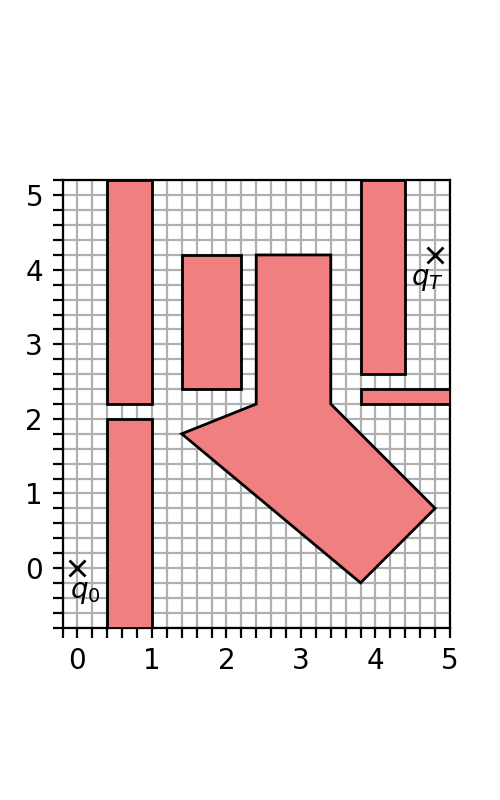

In [21]:
plt.figure(figsize=(2.5,4))

for O in obstacles:
    plt.fill(*O.T, fc='lightcoral', ec='k', zorder=4)

plt.plot(*x_start, 'kx')
plt.plot(*x_goal, 'kx')

plt.text(.1, -.4, '$q_0$', ha='center')
plt.text(4.7, 3.8, '$q_T$', ha='center')

plt.axis('square')
x_min = np.min(np.vstack(vertices), axis=0)
x_max = np.max(np.vstack(vertices), axis=0)
plt.xlim([x_min[0], x_max[0]])
plt.ylim([x_min[1], x_max[1]])

x_ticks = np.linspace(-.2, 5., 27)
y_ticks = np.linspace(-.8, 5.2, 31)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

keep = lambda t: np.isclose(t % .5, 0) or np.isclose(t % .5, .5)
x_labels = [int(t) if keep(t) else '' for t in x_ticks]
y_labels = [int(t) if keep(t) else '' for t in y_ticks]
plt.gca().set_xticklabels(x_labels)
plt.gca().set_yticklabels(y_labels)
plt.grid(1)
plt.savefig('setup.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


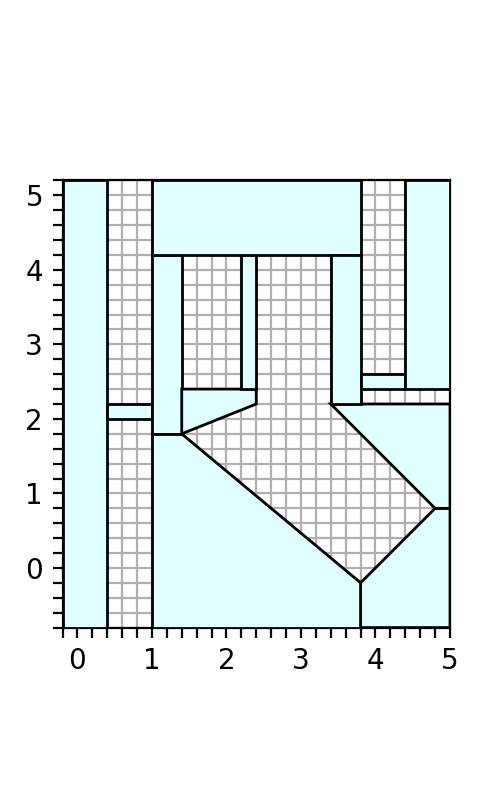

In [22]:
plt.figure(figsize=(2.5,4))

for V in vertices:
    plot_vpolytope(V, fc='lightcyan', ec='k', zorder=4)

plt.axis('square')
plt.xlim([x_min[0], x_max[0]])
plt.ylim([x_min[1], x_max[1]])

plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.gca().set_xticklabels(x_labels)
plt.gca().set_yticklabels(y_labels)
plt.grid(1)

plt.savefig('decomposition.pdf', bbox_inches='tight')

In [29]:
n_samples = 500
relaxation = False
velocity_limits = np.array([[[-1, -1], [1, 1]]])

def solve_linear():
    l_spp = LinearSPP(regions)
    waypoints, _, _ = l_spp.SolvePath(x_start, x_goal, relaxation)
    t_knots = np.linspace(0, 1,  waypoints.shape[1])
    l_traj = PiecewisePolynomial.FirstOrderHold(t_knots, waypoints)
    l_times = np.linspace(
        l_traj.start_time(),
        l_traj.end_time(),
        n_samples
    )
    return l_traj, l_times


def solve_bezier(order, continuity):
    weights = {'time': 1}
    b_spp = BezierSPP(regions,
                      order=order,
                      continuity=continuity,
                      weights=weights,
                      deriv_limits=velocity_limits)
    b_traj, _, _, b_r, b_h = b_spp.SolvePath(x_start, x_goal, relaxation)
    b_times = np.linspace(
        b_traj.start_time(),
        b_traj.end_time(),
        n_samples
    )
    return b_traj, b_times#, b_r, b_h

In [30]:
def h_inverse(t, h, tol=1e-9):
    s_min = h.start_time()
    s_max = h.end_time()
    h_min = h.value(s_min)[0,0]
    h_max = h.value(s_max)[0,0]
    if t < h_min or t > h_max:
        raise ValueError()
    while s_max - s_min > tol:
        s_split = (s_max - s_min) / 2 + s_min
        h_split = h.value(s_split)[0,0]
        if t >= h_split:
            s_min = s_split
        if t < h_split:
            s_max = s_split
    return s_split

In [31]:
q, q_times, r, h = solve_bezier(3, 1)
plt.figure()
r_times = np.linspace(r.start_time(), r.end_time(), 500)
h_times = np.linspace(h.start_time(), h.end_time(), 500)
r_eval = np.array([r.value(s)[0] for s in r_times])
h_eval = np.array([h.value(s)[0] for s in h_times])
q_eval = np.array([q.value(t)[0] for t in q_times])
qdot_eval = np.array([q.EvalDerivative(t)[0] for t in q_times])
hdotinv_eval = np.array([1/h.EvalDerivative(h_inverse(t, h))[0] for t in q_times])
my_qdot_eval = np.array([r.EvalDerivative(h_inverse(t, h))[0]/h.EvalDerivative(h_inverse(t, h))[0] for t in q_times])
plt.plot(r_times, r_eval, label='r')
plt.plot(h_times, h_eval, label='h')
plt.plot(q_times, q_eval, label='q')
plt.plot(q_times, qdot_eval, label='qdot')
# plt.plot(q_times, my_qdot_eval, label='my qdot')
# plt.plot(q_times, np.minimum(hdotinv_eval, 10), label='my hdot inv')
# plt.plot(h_times, np.zeros(h_times.shape), label='0')
plt.legend()

ValueError: not enough values to unpack (expected 4, got 2)

<IPython.core.display.Javascript object>


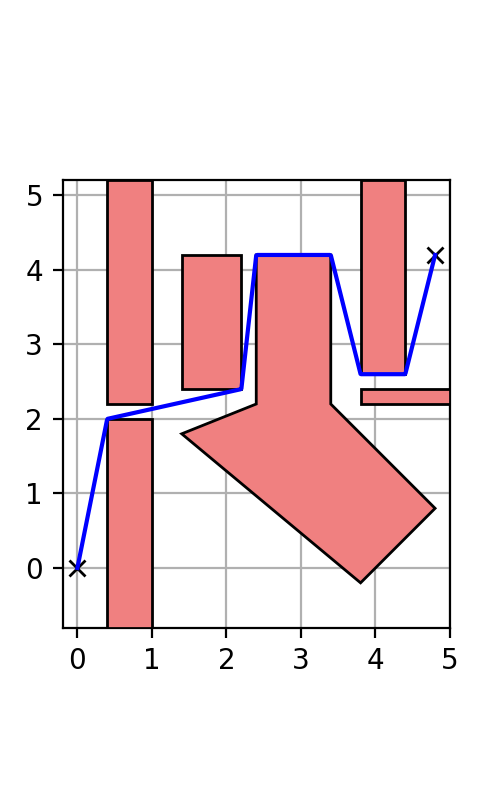

In [32]:
def plot_trajectory(traj, times):

    plt.figure(figsize=(2.5,4))

    for O in obstacles:
        plt.fill(*O.T, fc='lightcoral', ec='k', zorder=4)

    plt.plot(*x_start, 'kx')
    plt.plot(*x_goal, 'kx')

    plt.axis('square')
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    
    plt.xticks(range(6))

    values = np.squeeze([traj.value(t) for t in times])
    plt.plot(*values.T, 'b', zorder=5)

    plt.grid(1)
    
plot_trajectory(*solve_linear())
plt.savefig('linear.pdf', bbox_inches='tight')

In [33]:
def plot_velocity(traj, times):

    plt.figure(figsize=(2.5,1.5))
    velocity = np.array([traj.EvalDerivative(t) for t in times])
    plt.plot(times, np.ones(len(times)), 'r--', label='Lim.', linewidth=3)
    plt.plot(times, -np.ones(len(times)), 'r--', linewidth=3)
    plt.plot(times[1:-1], velocity[1:-1, 0], label='Hor.')
    plt.plot(times[1:-1], velocity[1:-1, 1], label='Ver.')
#     plt.legend(bbox_to_anchor=(0,1.02,1,.2), loc='lower left',
#                 mode='expand', borderaxespad=0, ncol=3)
    plt.grid()
    plt.xticks(np.arange(6)*2)
    plt.yticks(np.linspace(-1, 1, 5))
    plt.xlim([times[0], times[-1]])

<IPython.core.display.Javascript object>


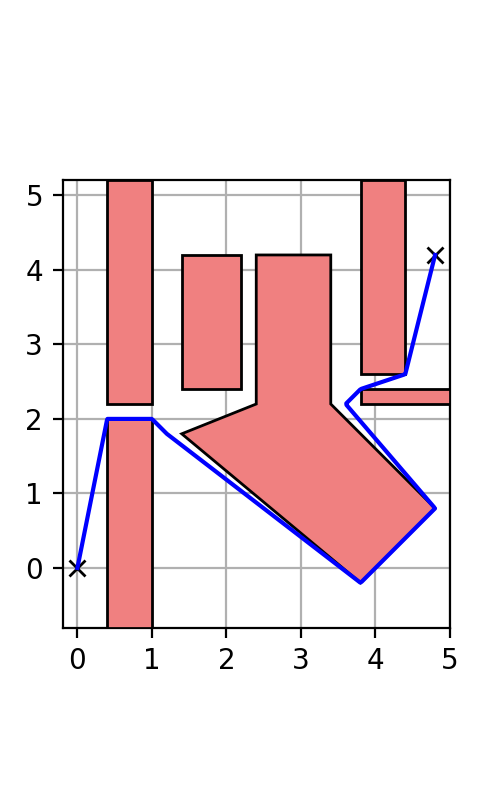

<IPython.core.display.Javascript object>


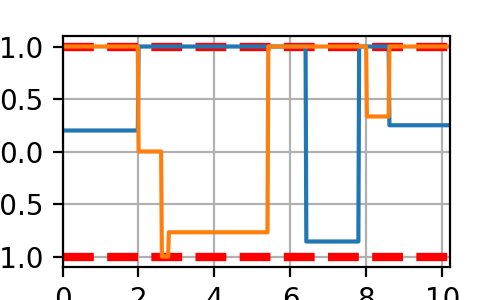

In [34]:
traj, times = solve_bezier(1, 0)

plot_trajectory(traj, times)
plt.savefig('bezier_10.pdf', bbox_inches='tight')

plot_velocity(traj, times)
plt.savefig('bezier_10_vel.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


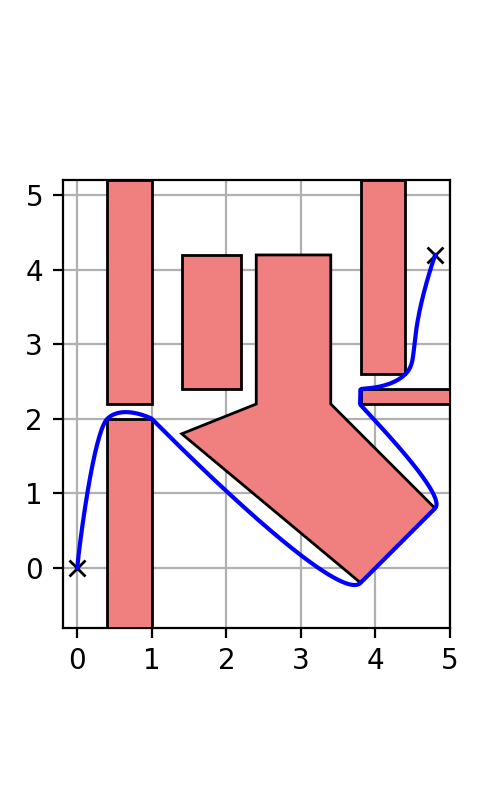

<IPython.core.display.Javascript object>


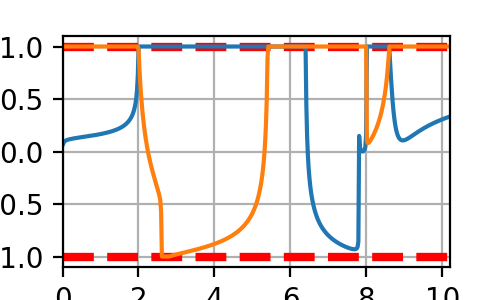

In [35]:
traj, times = solve_bezier(3, 1)

plot_trajectory(traj, times)
plt.savefig('bezier_31.pdf', bbox_inches='tight')

plot_velocity(traj, times)
plt.savefig('bezier_31_vel.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


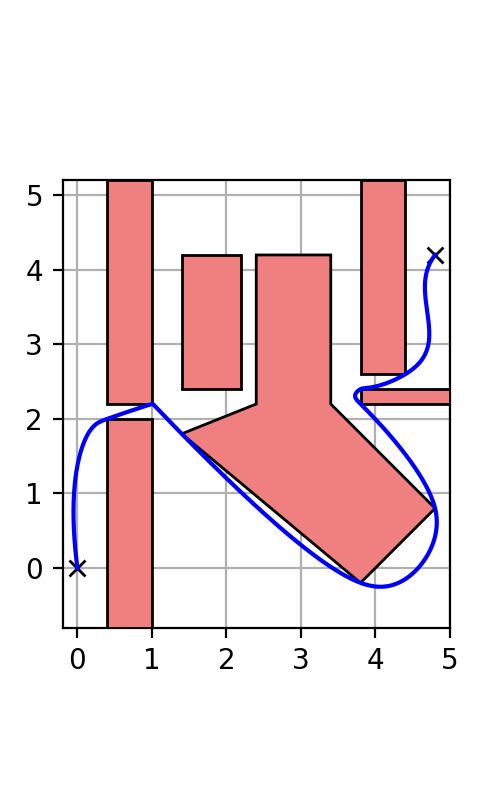

<IPython.core.display.Javascript object>


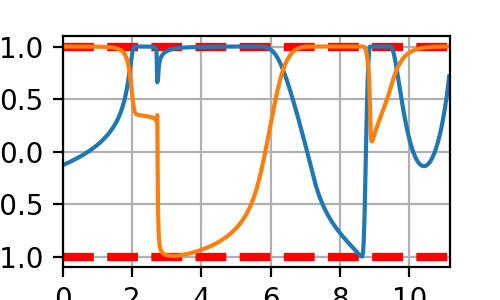

In [36]:
traj, times = solve_bezier(4, 2)

plot_trajectory(traj, times)
plt.savefig('bezier_42.pdf', bbox_inches='tight')

plot_velocity(traj, times)
plt.savefig('bezier_42_vel.pdf', bbox_inches='tight')